# Проверка разнообразия обучающей и тестовой выборки между собой и внутри

В данном блокноте приведена статистика сетов, similarity между и внутри сетов, а также детальный анализ схожих соединений по результатам similarity-анализа.
1. Подсчет активных и неактивных соединений в тесте, трэйне и исходном датасете
2. Подсчет разницы активных и неактивных соединений в %
3. Описательная статистика и графики распределения тест, трэйн и исходного датасета по значению pIC50.
4. Проведение Similarity-анализа между тест и трэйн:
    - Расчет Tanimoto_matrix
    - Подсчет количества соединений в различных диапазонах Tanimoto_index.
    - Построение графика распределения по парным значениям Tanimoto_index.
5. Анализ соединений с парным Tanimoto_index = 1 в пункте 4.
    - Функция stereo_review_calc ищет такие соединения и расчитывает разницу в их активности (как классов, так и разницы в IC50_nM). Средняя разница получилась 33 583 nM, что довольно существенно для расчетов (с учетом того, что граница активности была определена как 10 000 nM).
4. Проведение Similarity-анализа внутри тест и трэйн. Вывод: тестовая выборка более разнообразна, чем трэйн.



In [28]:
from pathlib import Path
import sys
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, DataStructs, AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
from pandas import DataFrame
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from rdkit.Chem import PandasTools
from tqdm import tqdm

In [29]:
# df1 = pd.read_table('herg_out_smaller_right.csv', sep = ",", engine='python')

In [30]:
df1 = PandasTools.LoadSDF('herg_smaller_right.sdf',molColName='ROMol')

In [31]:
df1["pIC50"] = df1["pIC50"].astype({"pIC50": float})

In [51]:
df1["MW"] = df1["MW"].astype({"MW": float})

In [32]:
df1["class"] = df1["class"].astype({"class": int})

Посмотрим на распределение теста, трэйна и самого датасета

In [33]:
def count_active_inactive_difference(df):
    # подсчет числа активных и неактивных соединений и считает их разницу в %
    count_active_inactive_ = Counter()
    for i in df["class"]:
        if i == 1:
            count_active_inactive_["active"]+=1
        else:
            count_active_inactive_["inactive"]+=1
    difference = ((count_active_inactive_["inactive"]-count_active_inactive_["active"])/(count_active_inactive_["active"]+count_active_inactive_["inactive"]))*100
    return count_active_inactive_, difference

In [34]:
count, diff = count_active_inactive_difference(df1)
print(count, f'difference={diff}')

Counter({'inactive': 4127, 'active': 3752}) difference=4.759487244574184


In [35]:
# Данные отличаются на 4.56 %. Больше неактивных. Несмотря на то, что выборка сбалансирована по прежнему основная метрика для сравнения - roc_auc.

In [36]:
Y = df1
X = df1
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, random_state=75, train_size=.8)

In [37]:
len(y_train)

6303

In [38]:
len(y_test)

1576

In [39]:
count, diff = count_active_inactive_difference(y_train)
print(count, f'difference={diff}')

Counter({'inactive': 3326, 'active': 2977}) difference=5.537045851181977


In [40]:
count, diff = count_active_inactive_difference(y_test)
print(count, f'difference={diff}')

Counter({'inactive': 801, 'active': 775}) difference=1.6497461928934012


In [41]:
# разница почти сохраняется в % после деления на трэйн и тест.

In [66]:
def plot_pIC50(df1, name, value):
    # функция для построения распределения по значению pIC50
    c,me,std,mi,procent1, procent2, procent3, ma = df1[value].describe().round(4)
    n, bins, patches = plt.hist(df1[value], 50, density=True, alpha=0.9)

    plt.xlabel(value)
    plt.ylabel('Probability')
    plt.title(f'{name}')
    plt.xlim(0, np.max(df1[value]))
    plt.annotate(f'count={c}\nmean={me}\nstd={std}\nmin={mi}\n25%={procent1}\n50%={procent2}\n75%={procent3}\nmax={ma}', xy=(0.5, 0.2))
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

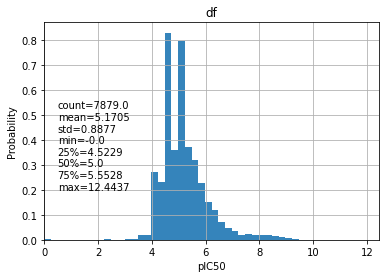

In [67]:
plot_pIC50(df1, name='df', value ='pIC50')

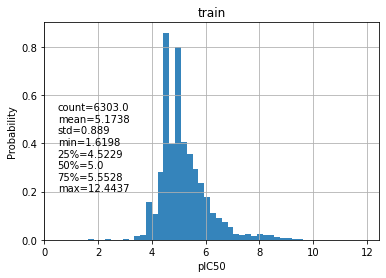

In [68]:
plot_pIC50(y_train, name="train", value ='pIC50')

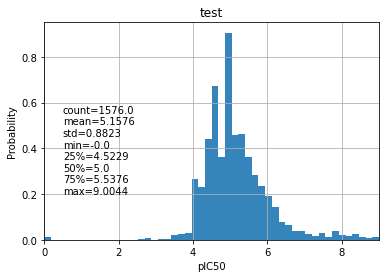

In [69]:
plot_pIC50(y_test, name= "test", value ='pIC50')

Также посмотрим распределение по молекулярной массе:

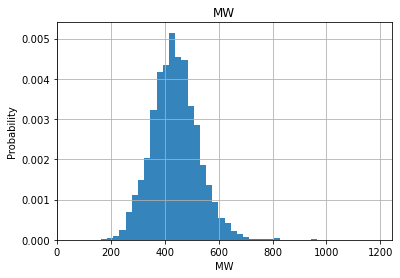

In [70]:
plot_pIC50(df1, name='MW', value ='MW')

# Рассчитаем similarity между и внутри train&test

Вначале между тест и трэйн

In [19]:
Y = df1["class"]
X = df1
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, random_state=75, train_size=.8)

In [43]:
# ! pip install tqdm

In [47]:
def calculate_tanimoto_matrix(X_train, X_test):
    # Для каждого значения из теста расчитает индекс Танимото с каждым соединением из трэйна. Получим матрицу.
    mols_train = list(X_train["ROMol"])
    mols_test = list(X_test["ROMol"])
    fp_mg2_bin = [AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mols_train]
    fp_mg2_bin_test = [AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mols_test]
    df = pd.DataFrame(index=range(1),columns=range(len(X_train)))
    for idx in tqdm(range(len(fp_mg2_bin_test))):
        tanimoto_mg2_bin = DataStructs.BulkTanimotoSimilarity(fp_mg2_bin_test[idx], [fp for i, fp in enumerate(fp_mg2_bin)])
        df_length = len(df)
        df.loc[df_length] = tanimoto_mg2_bin
    df = df.iloc[1: , :]
    return(df, mols_test, mols_train, fp_mg2_bin, fp_mg2_bin_test)

In [48]:
df, mols_test, mols_train, fp_mg2_bin, fp_mg2_bin_test = calculate_tanimoto_matrix(X_train, X_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1576/1576 [00:42<00:00, 37.51it/s]


In [49]:
df

,0,1,2,3,4,5,6,7,8,9,...,6293,6294,6295,6296,6297,6298,6299,6300,6301,6302
1,0.083333,0.126506,0.119718,0.077519,0.091954,0.074627,0.092199,0.110294,0.187500,0.065693,...,0.091549,0.078571,0.067568,0.095238,0.084967,0.167939,0.075630,0.077465,0.075472,0.111111
2,0.079646,0.111801,0.110294,0.100840,0.116564,0.088000,0.089552,0.117188,0.142857,0.086614,...,0.088889,0.117188,0.094891,0.092857,0.112676,0.141732,0.081081,0.098485,0.101351,0.148936
3,0.069767,0.071942,0.080357,0.063158,0.078014,0.070707,0.104762,0.066038,0.085714,0.058824,...,0.093458,0.066038,0.034483,0.108108,0.075630,0.064815,0.111111,0.074766,0.099174,0.090909
4,0.129630,0.104938,0.110294,0.082645,0.116564,0.105691,0.073529,0.091603,0.116279,0.086614,...,0.113636,0.083333,0.079137,0.092857,0.112676,0.160000,0.081081,0.106870,0.065359,0.140845
5,0.076923,0.099291,0.032520,0.103093,0.060403,0.142857,0.119266,0.091743,0.111111,0.055556,...,0.069565,0.062500,0.076923,0.084034,0.072000,0.090090,0.078652,0.070796,0.130081,0.095238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,0.076923,0.094444,0.097403,0.049296,0.111111,0.100000,0.138889,0.080537,0.080000,0.075862,...,0.100000,0.087838,0.076923,0.042683,0.086420,0.079470,0.104000,0.124138,0.103659,0.104294
1573,0.088710,0.103448,0.086093,0.058824,0.120690,0.137405,0.081633,0.114286,0.105634,0.055944,...,0.088435,0.083333,0.072368,0.084967,0.096154,0.089655,0.117647,0.128571,0.093168,0.114650
1574,0.104167,0.125000,0.125749,0.120000,0.106061,0.067901,0.095808,0.097561,0.096970,0.086957,...,0.108434,0.125000,0.100000,0.137725,0.114286,0.109756,0.105634,0.103030,0.098901,0.124294
1575,0.091743,0.093168,0.072464,0.113043,0.111801,0.055556,0.117188,0.093750,0.068182,0.080000,...,0.125000,0.076923,0.080882,0.071429,0.076389,0.075758,0.044643,0.059701,0.111111,0.104167


In [50]:
#  Сортируем и выбираем максимальные значения индекса Танимото по каждой строчке

In [51]:
df1_sort = df.max(axis = 1)
df1_sort

1       0.706522
2       0.597701
3       0.911111
4       0.731707
5       0.603175
          ...   
1572    0.792079
1573    0.821053
1574    0.747967
1575    0.775000
1576    0.613861
Length: 1576, dtype: float64

In [52]:
def count_tanimoto_range_3(df1, dot1, dot2):
    # данная функция расчитывает диапазон по индексу Танимото, куда попали пары соедиений. Диапазон из 3 частей.
    count_ = Counter()
    for i in df1:
        if i <= dot1:
            count_[f"Tanimoto_index = 0.00 - {dot1}"]+=1
        elif i <= dot2 and i > dot1:
            count_[f"Tanimoto_index = {dot1} - {dot2}"]+=1
        elif i >  dot2:
            count_[f"Tanimoto_index = {dot2} - 1.00"]+=1
    return count_

In [53]:
count_ = count_tanimoto_range_3(df1_sort, 0.33, 0.66)
print(count_)

Counter({'Tanimoto_index = 0.66 - 1.00': 1056, 'Tanimoto_index = 0.33 - 0.66': 419, 'Tanimoto_index = 0.00 - 0.33': 101})


In [54]:
def count_tanimoto_range_2(df1, dot1):
    # Функция показывает число соединений в диапазоне dot1-1.0.
    count_ = Counter()
    for i in df1:
        if i > dot1:
            count_[f"Tanimoto_index = {dot1} - 1.00"]+=1
    return count_

In [55]:
count_ = count_tanimoto_range_2(df1_sort, 0.8)
print(count_)

Counter({'Tanimoto_index = 0.8 - 1.00': 368})


In [56]:
def plot_pIC50_sort(df1_sort, name):
    # функция для построения распределения по значению индекса Танимото для пар соединений тест-трэйн
    c,me,std,mi,procent1, procent2, procent3, ma = df1_sort.describe().round(4)
    n, bins, patches = plt.hist(df1_sort, 50, density=True, alpha=0.9)

    plt.xlabel('Tanimoto_index')
    plt.ylabel('Probability')
    plt.title(f'{name}')
    plt.xlim(0, 1)
    plt.annotate(f'count={c}\nmean={me}\nstd={std}\nmin={mi}\n25%={procent1}\n50%={procent2}\n75%={procent3}\nmax={ma}', xy=(0.3, 1.5))
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.show()
    

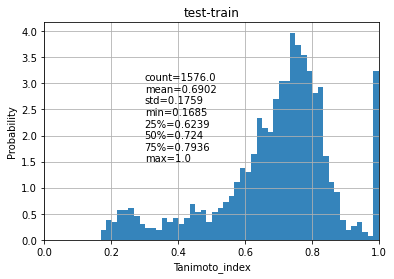

In [57]:
plot_pIC50_sort(df1_sort, name='test-train')

разберемся с теми соединениями, у которых индекс Танимото = 1

In [58]:
data = sum(np.where(df1_sort != 1, 0, 1))
data

85

93 соединения из теста имеют индекс Танимото = 1 с трэйном. Поскольку соединения с одинаковым ChEMBL_ID были удалены, то остались cтереоизомеры.

Функция, котрая сравнивает все соединения из трэйн и из теста по классу активности и по разнице в IC50_nM

In [61]:
# Функция, котрая сравнивает все соединения из трэйн и из теста по классу активности и по разнице в IC50_nM
def stereo_review_calc(df, X_train, X_test):
    df2_sort = df.max(axis = 0) # отбираем максимальные значения индекса Танимото в трэйне
    index_tanimoto_1_train = []
    for index, value in df2_sort.items(): #отбираем индексы тех соединений трэйна, для которых idT = 1.0 c некоторыми соединениями теста
        if value == 1.0:
            index_tanimoto_1_train.append(index)
    X_train.reset_index(drop=True, inplace=True) #обнуляем индексы у трэйна и теста, поскольку при генерации молекул из них индексы обнулялись(см функцию calculate_tanimoto_matrix генерация mols_train, mols_test)
    X_test.reset_index(drop=True, inplace=True)
    stereo_review = 0 # счетчик кол-ва стереоизомеров с одинаковой активностью по классу (1/0)
    stereo_review_diff = 0 # счетчик кол-ва стереоизомеров с разной активностью по классу (1/0)
    IC50_nM_diff = [] # будут записаны разницы в активности у стереизомеров в nM (IC50)
    s_same = pd.Series([0], index = [0]) # будет словарик с индексами из трэйна и теста тех пар стереоизомеров, чей класс активноси одинаков
    s_diff = pd.Series([0], index = [0]) # будет словарик с индексами из трэйна и теста тех пар стереоизмеров, чей класс активноси разный
    for train in tqdm(index_tanimoto_1_train): # цикл для того, чтобы понять какое именно соединение(индекс) из теста соответствует данному индексу из трэйна (т.е. составление пар стереоизмеров(словаря))
        #train = [i]
        number_of_others=0 # число других соединений теста, у которых при построении tanimoto_matrix не встречалось значение 1.0
        test = []
        for index, row in df.iterrows():
            value = row[train]
            if value == 1.0:
                test.append(index-1)
            else:
                number_of_others+=1
        dict_stereo = pd.Series([int(test[0])], index=[train])
        # проверка: в результате данного цикла мы должны были оторать пару стереоизмеров (тест-трэйн). Т.е. число других в тесте должно быть len(X_test)-1.
        if number_of_others == len(X_test)-1:
            if int(X_train.loc[[train], "class"]) == int(X_test.loc[[int(test[0])], "class"]):
                stereo_review += 1               
                s_same = s_same.append(dict_stereo)
            else:
                stereo_review_diff +=1
                s_diff = s_diff.append(dict_stereo)
            diff = abs(float(X_train.loc[[train], "value_nM"])- float(X_test.loc[[int(test[0])], "class"]))
            IC50_nM_diff.append(diff)
        else: # но бывает, что на одно соединение в трэйне приходятся аж два стереоизомера из теста, это тоже надо учесть. В таком случае далее в списке test у нас будет list из двух значений (двух индексов)
            if (len(X_test)-1)-number_of_others == 1:
                if int(X_train.loc[[train], "class"]) == int(X_test.loc[[int(test[0])], "class"]):
                    stereo_review += 1
                    s_same = s_same.append(dict_stereo)
                else:
                    stereo_review_diff +=1
                    s_diff = s_diff.append(dict_stereo)
                diff = abs(float(X_train.loc[[train], "value_nM"])- float(X_test.loc[[int(test[0])], "class"]))
                IC50_nM_diff.append(diff)
                dict_stereo_3 = pd.Series([int(test[1])], index=[train])
                if int(X_train.loc[[train], "class"]) == int(X_test.loc[[int(test[1])], "class"]):
                    stereo_review += 1
                    s_same = s_same.append(dict_stereo_3)
                else:
                    stereo_review_diff +=1
                    s_diff = s_diff.append(dict_stereo_3)
                diff = abs(float(X_train.loc[[train], "value_nM"])- float(X_test.loc[[int(test[1])], "class"]))
                IC50_nM_diff.append(diff)
    del s_same[0]
    del s_diff[0]
    return(stereo_review,stereo_review_diff,IC50_nM_diff,index_tanimoto_1_train,s_same,s_diff)
            

In [62]:
stereo_rewiew,stereo_rewiew_diff,IC50_nM_diff,index_tanimoto_1_train,s_same,s_diff  = stereo_review_calc(df, X_train, X_test)

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:07<00:00, 13.39it/s]


In [63]:
print (f"Number of compounds with the same IC50 class = {stereo_rewiew}")
print (f"Number of compound with the different IC50 class = {stereo_rewiew_diff}")
print (f"Mean of difference in IC50 nM = {np.mean(IC50_nM_diff)}")

Number of compounds with the same IC50 class = 93
Number of compound with the different IC50 class = 15
Mean of difference in IC50 nM = 35881.505


Далее слева - индекс трэйна, справа - теста

In [64]:
len(s_diff)

15

In [65]:
s_diff

6        758
122     1418
257      474
338       14
1477    1060
1673    1194
3370      14
3458    1109
3737    1030
4564    1418
5043     862
5478     564
5493     846
5818     881
5834     230
dtype: int64

In [66]:
s_diff.to_csv("s_diff.csv", encoding='utf-8', index=True)

Взглянем на стереомеры, различные по активности:

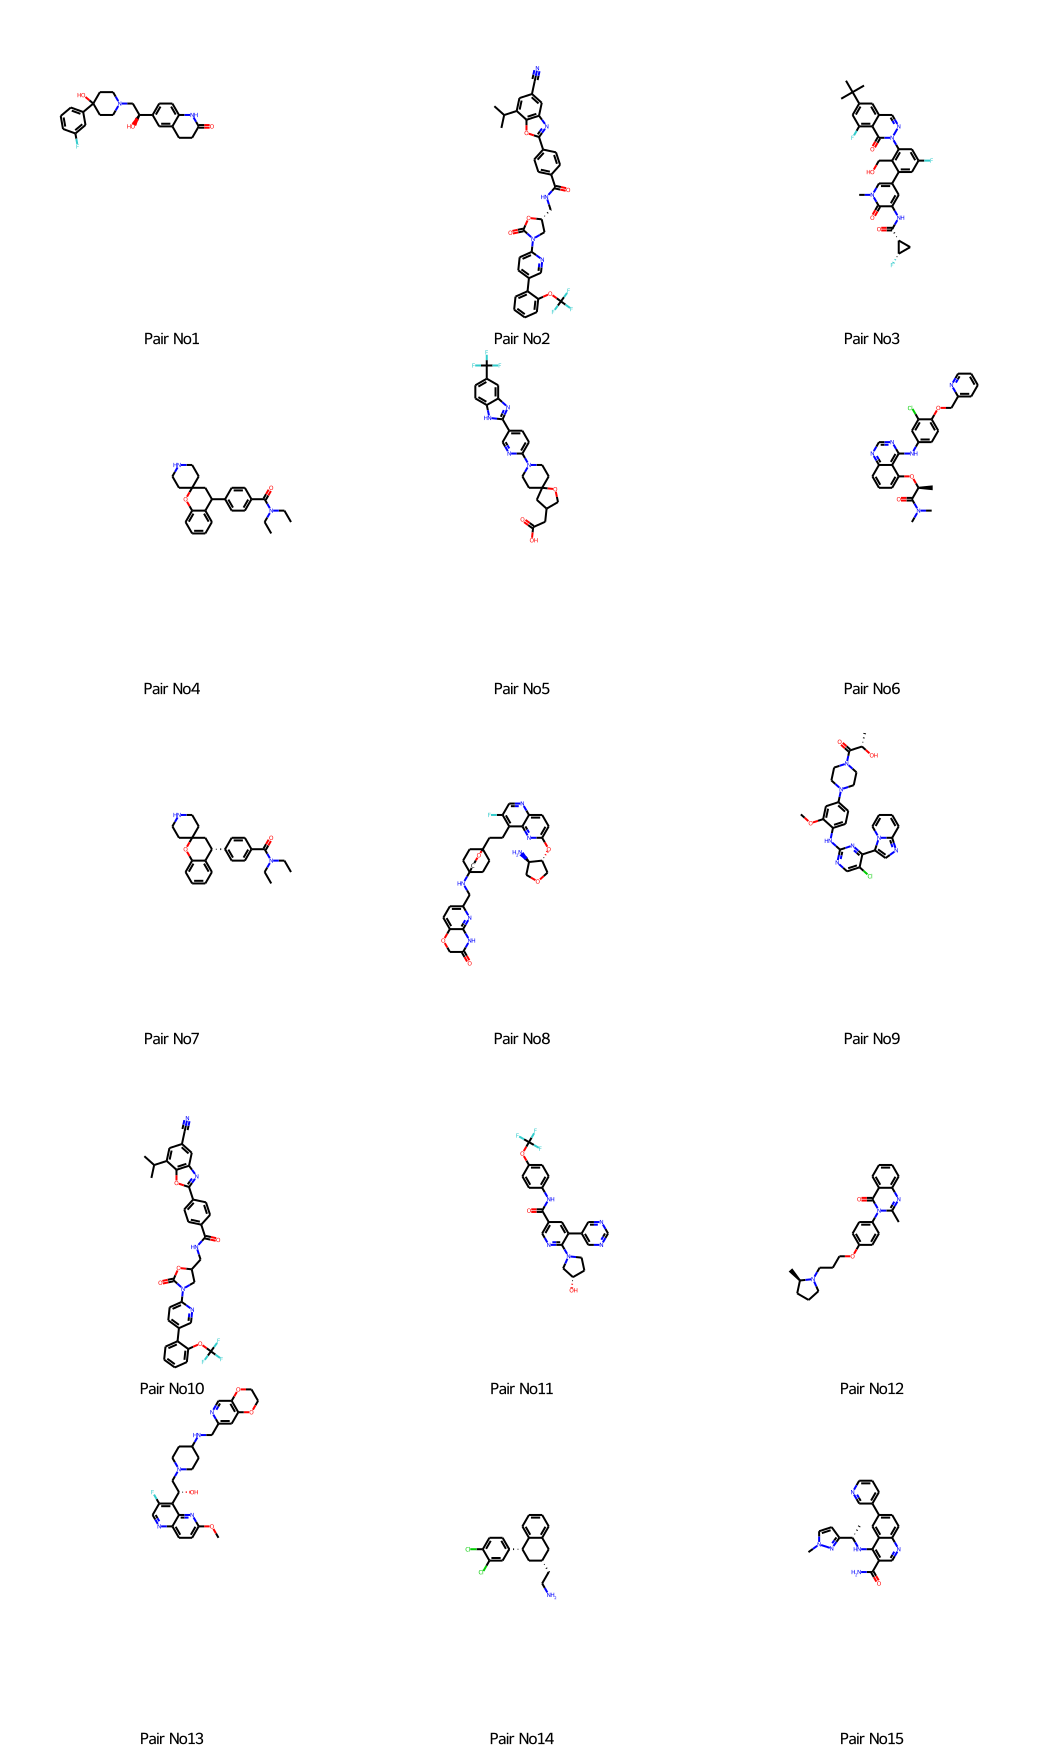

In [67]:
legend = ['Pair No' + str(i+1) for i in range(21)]
Draw.MolsToGridImage([mols_train[i] for i in s_diff.keys()], subImgSize=(350, 350), legends=legend, molsPerRow=3)

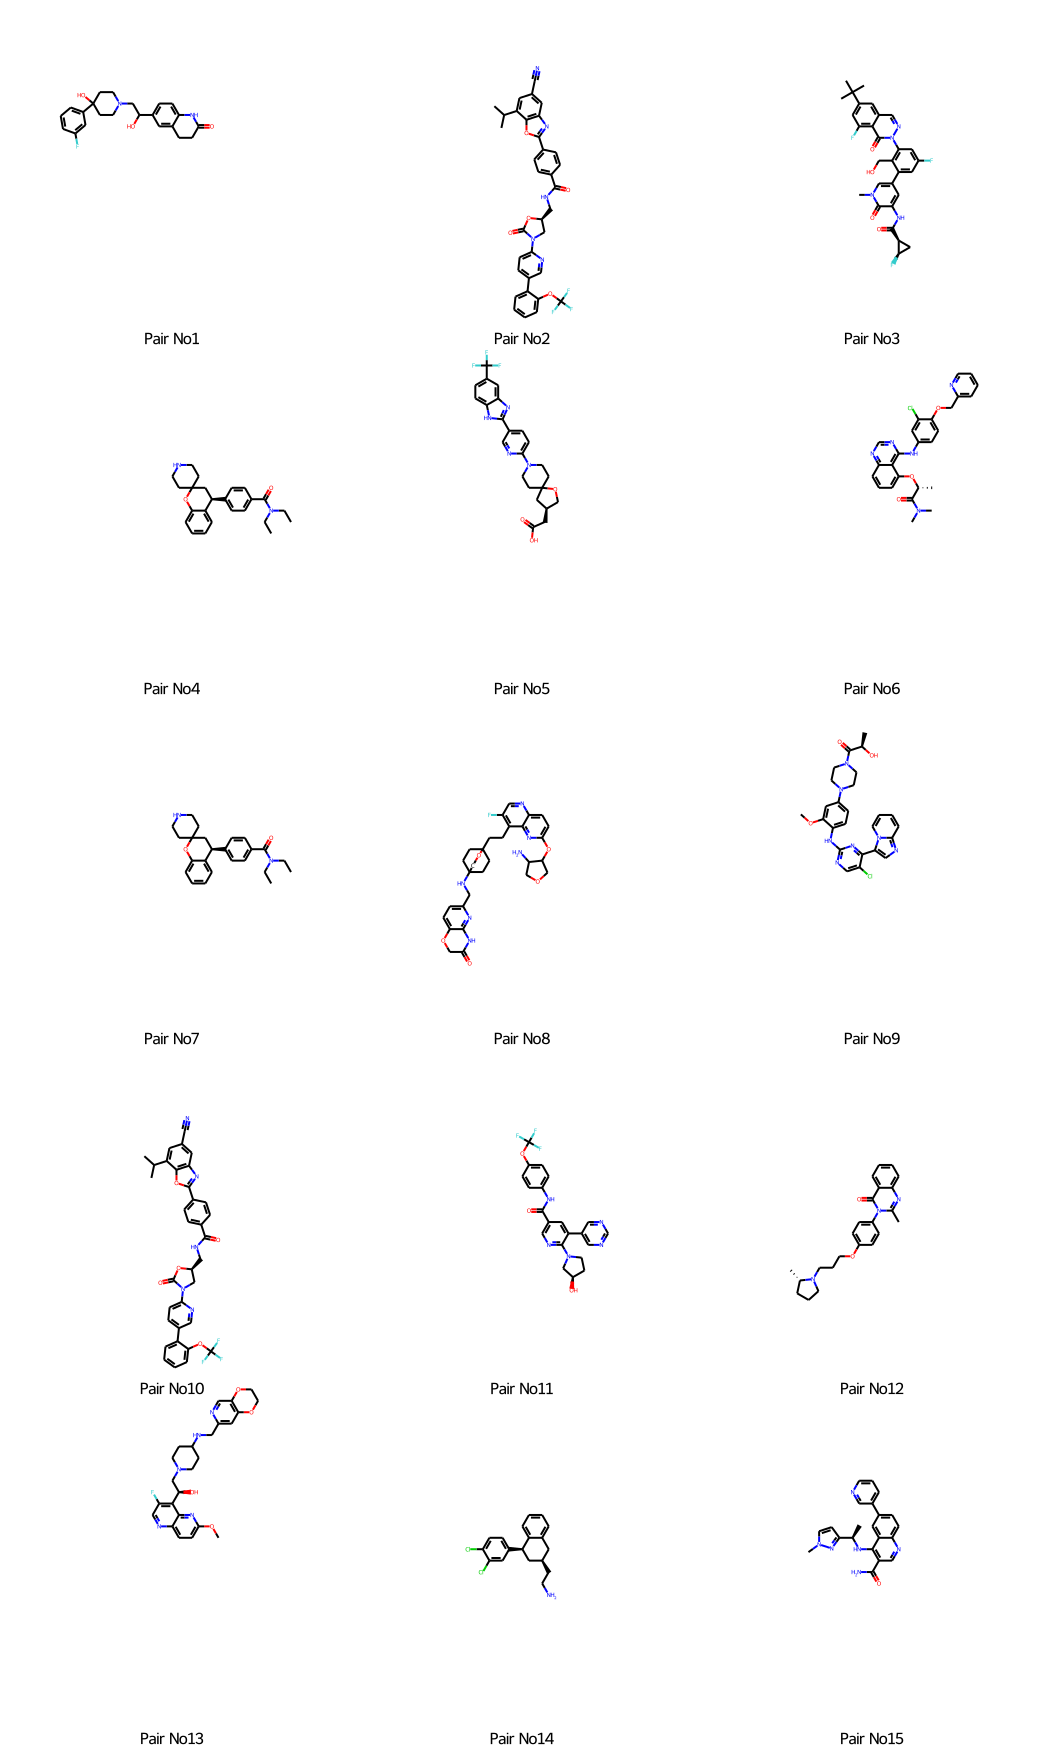

In [68]:
legend = ['Pair No' + str(i+1) for i in range(21)]
Draw.MolsToGridImage([mols_test[i] for i in s_diff.values], subImgSize=(350, 350), legends=legend, molsPerRow=3)

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
453,NC(=O)c1cnc(N(CCO)[C@H]2CCCNC2)c2cc(-c3ccccc3)...,CHEMBL4076939,>,IC50,nM,uM,31.6,396.516,31600.0,0,4.500313,,

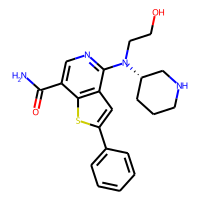

In [69]:
X_train.loc[[453]]

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
1020,Cn1cnc(C(=O)N(Cc2ccc(F)c(Cl)c2)C[C@@H]2[C@H]3C...,CHEMBL560289,=,IC50,nM,nM,14600.0,362.836,14600.0,0,4.835647,,

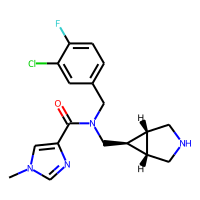

In [70]:
X_test.loc[[1020]]

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
1,Cc1ccc(C(=O)Nc2ccc(CN3Cc4cn[nH]c4C3)c(Cl)c2)cc...,CHEMBL4638981,=,IC50,nM,uM,12.1,507.985,12100.0,0,4.917215,,

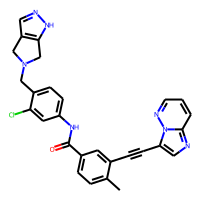

In [71]:
X_train.loc[[1]]

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
1,Cc1ccc(C(=O)Nc2ccc(CN3Cc4cn[nH]c4C3)c(Cl)c2)cc...,CHEMBL4638981,=,IC50,nM,uM,12.1,507.985,12100.0,0,4.917215,,

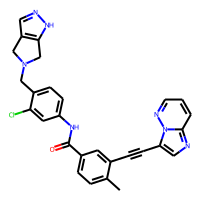

In [72]:
X_train.iloc[[1]]

In [73]:
# pd.set_option('display.max_colwidth', None) # 0 - чтобы обратно сокращал, чтобы посмотреть полный smiles, проверить

In [74]:
# n = DataStructs.FingerprintSimilarity(fp_mg2_bin[int(train[0])], fp_mg2_bin_test[int(test[0])]) проверить, какой индекс у двух молекул

# Вернемся к similarity

Теперь рассчитаем similarity внутри трэйна и теста

Внутри теста:

In [80]:
def calculate_tanimoto_matrix_inside(X_test, fp_mg2_bin_test):
# Помимо работы calculate_tanimoto_matrix, данная функция также обнуляет значения по диагонали (они нам не интересны, это индекс Танимото соединения самого с собой, равен 1.0), а также расчитывает и выводит время расчетов (актуально для больших датасетов)
    df = pd.DataFrame(index=range(1),columns=range(len(X_test)))
    #t0 = time.time()
    for idx in tqdm(range(len(fp_mg2_bin_test))):
        #t1 = time.time()
        #print("Processing compound {} ({}%)".format(idx, 100*idx//len(fp_mg2_bin_test)), end="")
        tanimoto_mg2_bin = DataStructs.BulkTanimotoSimilarity(fp_mg2_bin_test[idx], [fp for i, fp in enumerate(fp_mg2_bin_test)])
        df_length = len(df)
        df.loc[df_length] = tanimoto_mg2_bin
        #t2 = time.time()
        #print(" {}s (total: {}s)".format(t2-t1, t2-t0))
    df = df.iloc[1: , :]
    df1 = df.where(df.values != np.diag(df),0,df.where(df.values != np.flipud(df).diagonal(0),0,inplace=True))
    return (df1)

In [81]:
df1 = calculate_tanimoto_matrix_inside(X_test, fp_mg2_bin_test)

100%|█████████████████████████████████████████████████████████████████████████████| 1576/1576 [00:12<00:00, 129.27it/s]
C:\Users\Elly\AppData\Local\Temp/ipykernel_22580/1752144277.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.where except for the arguments 'cond' and 'other' will be keyword-only
  df1 = df.where(df.values != np.diag(df),0,df.where(df.values != np.flipud(df).diagonal(0),0,inplace=True))


In [82]:
df1

,0,1,2,3,4,5,6,7,8,9,...,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575
1,0.000000,0.142857,0.079646,0.142857,0.094017,0.094340,0.104478,0.064935,0.077465,0.132812,...,0.079755,0.083333,0.114458,0.117647,0.058394,0.075949,0.092715,0.138554,0.137405,0.000000
2,0.142857,0.000000,0.096154,0.090909,0.090909,0.121622,0.000000,0.083333,0.090226,0.122951,...,0.112583,0.071429,0.113208,0.090909,0.104839,0.087248,0.105634,0.117284,0.000000,0.122302
3,0.079646,0.096154,0.000000,0.055556,0.111111,0.133333,0.089109,0.058824,0.263736,0.091837,...,0.061538,0.082474,0.088889,0.096154,0.070000,0.056000,0.085470,0.000000,0.088235,0.095652
4,0.142857,0.090909,0.055556,0.000000,0.061947,0.121622,0.102362,0.075862,0.066176,0.053846,...,0.076923,0.115702,0.113208,0.090909,0.070312,0.058824,0.000000,0.110429,0.110236,0.114286
5,0.094017,0.090909,0.111111,0.061947,0.000000,0.067669,0.054545,0.064516,0.070796,0.086538,...,0.058824,0.067308,0.092857,0.081081,0.066038,0.000000,0.064000,0.075342,0.083333,0.081967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,0.075949,0.087248,0.056000,0.058824,0.000000,0.108434,0.082192,0.094340,0.051613,0.083916,...,0.087719,0.069930,0.107955,0.102041,0.099291,0.000000,0.114650,0.087432,0.067114,0.074074
1573,0.092715,0.105634,0.085470,0.000000,0.064000,0.084848,0.077465,0.104575,0.097222,0.079137,...,0.110429,0.080292,0.130952,0.090278,0.102941,0.114650,0.000000,0.114943,0.076923,0.090323
1574,0.138554,0.117284,0.000000,0.110429,0.075342,0.153409,0.085890,0.084270,0.123457,0.054545,...,0.108108,0.068323,0.120419,0.117284,0.074074,0.087432,0.114943,0.000000,0.155844,0.096591
1575,0.137405,0.000000,0.088235,0.110236,0.083333,0.086667,0.087302,0.077465,0.100775,0.072000,...,0.085526,0.118644,0.094340,0.101562,0.080645,0.067114,0.076923,0.155844,0.000000,0.150376


In [83]:
df1 = df1.max(axis = 1)
df1

1       0.777778
2       0.260163
3       0.692308
4       0.318182
5       0.567164
          ...   
1572    0.782178
1573    0.491228
1574    0.687023
1575    0.716049
1576    0.673469
Length: 1576, dtype: float64

In [84]:
count_ = count_tanimoto_range_3(df1, 0.33, 0.66)
print(count_)

Counter({'Tanimoto_index = 0.33 - 0.66': 654, 'Tanimoto_index = 0.66 - 1.00': 601, 'Tanimoto_index = 0.00 - 0.33': 321})


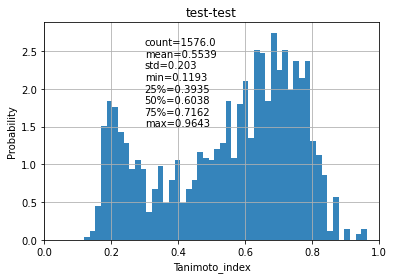

In [85]:
plot_pIC50_sort(df1, name='test-test')

То же самое для трэйна:

Осторожно, считается 14 минут. Т.е. увеличение датасета в 4 раза дает увеличение времени расчета в 50 раз... 

In [86]:
df1 = calculate_tanimoto_matrix_inside(X_train, fp_mg2_bin)

100%|██████████████████████████████████████████████████████████████████████████████| 6303/6303 [10:07<00:00, 10.38it/s]
C:\Users\Elly\AppData\Local\Temp/ipykernel_22580/1752144277.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.where except for the arguments 'cond' and 'other' will be keyword-only
  df1 = df.where(df.values != np.diag(df),0,df.where(df.values != np.flipud(df).diagonal(0),0,inplace=True))


In [87]:
df1

,0,1,2,3,4,5,6,7,8,9,...,6293,6294,6295,6296,6297,6298,6299,6300,6301,6302
1,0.000000,0.090278,0.057377,0.101010,0.059603,0.055556,0.087719,0.198020,0.079646,0.054545,...,0.068376,0.061404,0.066667,0.082645,0.105691,0.108108,0.065217,0.051282,0.093023,0.000000
2,0.090278,0.000000,0.087719,0.077922,0.107143,0.096154,0.103659,0.098765,0.098160,0.067901,...,0.064327,0.105590,0.057143,0.099415,0.090395,0.139241,0.076389,0.125000,0.000000,0.119318
3,0.057377,0.087719,0.000000,0.086614,0.111765,0.075188,0.069930,0.086957,0.152672,0.082090,...,0.069444,0.127820,0.060811,0.066667,0.114865,0.160305,0.076271,0.000000,0.096774,0.097403
4,0.101010,0.077922,0.086614,0.000000,0.056250,0.069565,0.072581,0.111111,0.139130,0.050420,...,0.063492,0.056911,0.151261,0.052632,0.082090,0.128205,0.000000,0.047619,0.094891,0.071942
5,0.059603,0.107143,0.111765,0.056250,0.000000,0.101266,0.101796,0.083832,0.083333,0.106918,...,0.114458,0.117284,0.074286,0.067039,0.113636,0.000000,0.082192,0.165605,0.086486,0.129944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6299,0.108108,0.139241,0.160305,0.128205,0.000000,0.122951,0.072993,0.142857,0.450000,0.053030,...,0.096296,0.125000,0.143939,0.092199,0.111888,0.000000,0.110092,0.131783,0.100671,0.124138
6300,0.065217,0.076389,0.076271,0.000000,0.082192,0.120000,0.079646,0.072072,0.111111,0.045872,...,0.051282,0.122642,0.058824,0.102564,0.063492,0.110092,0.000000,0.100000,0.069231,0.095238
6301,0.051282,0.125000,0.000000,0.047619,0.165605,0.151261,0.057554,0.090909,0.115385,0.069231,...,0.112782,0.116279,0.078571,0.107914,0.067114,0.131783,0.100000,0.000000,0.078947,0.101351
6302,0.093023,0.000000,0.096774,0.094891,0.086486,0.099291,0.422414,0.094595,0.101351,0.068027,...,0.084967,0.080000,0.069620,0.095541,0.127389,0.100671,0.069231,0.078947,0.000000,0.090361


In [88]:
df1 = df1.max(axis = 1)
df1

1       0.600000
2       0.745902
3       0.758621
4       0.589744
5       0.820513
          ...   
6299    0.651685
6300    0.250000
6301    0.484211
6302    0.680000
6303    0.764706
Length: 6303, dtype: float64

In [89]:
count_ = count_tanimoto_range_3(df1, 0.33, 0.66)
print(count_)

Counter({'Tanimoto_index = 0.66 - 1.00': 4279, 'Tanimoto_index = 0.33 - 0.66': 1590, 'Tanimoto_index = 0.00 - 0.33': 434})


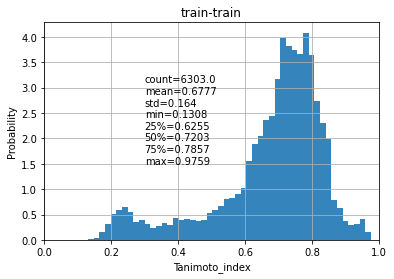

In [90]:
plot_pIC50_sort(df1, name='train-train')

# Вывод: 
- В результате сравнения обучающей и тестовой выборок по similarity было найдено 93 соединения из теста, имеющие с соединениями из трэйна  индекс Танимото = 1.0
- Стоит принять во внимание, что это не могли быть одинаковые соединения, поскольку у них разный ChEMBL ID (дубликаты по ChEMBL ID  были удалены в разделе data preparation).
- Оказалось, что данные соединения - стереоизомеры в 3D форме, которые в представлении Моргановских (и других топологических 2D-фингерпринтов) не различимы.
- Появилась необходимость проверить, насколько различаются активности у стереоизомеров (как по классу, так и по значению IC50 в нМ).
- В результате оказалось, что 20 пар соединений имеют разный класс активности. Средняя разница по IC50 у таких соединений составила 33 583 nM, что довольно существенно для расчетов (с учетом того, что граница активности (деление по классам) была определена как 10 000 nM).